This tutorial/notebook will demonstrate three-component beamforming using ObsPy. It will explain every step along the way.

Look at the 2003 San Simeon earthquake from the Parkfield array.

Interactive so feel free to experiment!

# Obtaining an Inventory

While all important information about the instruments in the array could be
obtained from the project's website at [...] and then manually fed into obspy, in this
case it is far easier to obtain this 'inventory' data through the webservice 
provided for the purpose under http://service.ncedc.org/. Because the format of these URLs and the provided webservices are standardised, it is very easy to connect to the NCEDC using obspy:

(Execute cells by clicking into them and pressing the 'play' button on top. It might take a little while to connect to the NCEDC's servers.)

In [1]:
# Use the FDSN webservice:
from obspy.clients.fdsn import Client
ncedc_client = Client("NCEDC")
# Check what's in it:
print(ncedc_client)

FDSN Webservice Client (base url: https://service.ncedc.org)
Available Services: 'dataselect' (v1.1.0), 'event' (v1.2.0), 'station' (v1.1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


As you can see, the FDSN client can provide seismic data, event catalogs, station information, etc. First, we're interested in station information for our network with the code BP. The webservice can provide different levels of information, with 'response' providing full response information for all requested channels. We only want the BP channels (BP1, BP2, BP3) of all stations in the network:

In [2]:
inv = ncedc_client.get_stations(network="BP", level="response")
inv = inv.select(channel="BP*")  # The * is a wildcard.
print(inv)

Inventory created at 2024-03-14T09:55:59.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.2
		    http://service.ncedc.org/fdsnws/station/1/query?net=BP&level=resp
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			BP
		Stations (14):
			BP.CCRB (Cholame Creek, Parkfield, CA, USA)
			BP.EADB (Eade Ranch, Parkfield, CA, USA)
			BP.FROB (Froelich Ranch, Parkfield, CA, USA)
			BP.GHIB (Gold Hill, Parkfield, CA, USA)
			BP.JCNB (Joaquin Canyon North, Parkfield, CA, USA)
			BP.JCSB (Joaquin Canyon South, Parkfield, CA, USA) (2x)
			BP.LCCB (Little Cholame Creek, Parkfield, CA, USA)
			BP.MMNB (Middle Mountain, Parkfield, CA, USA)
			BP.RMNB (Gastro Peak, Parkfield, CA, USA)
			BP.SCYB (Stone Canyon, Parkfield, CA, USA)
			BP.SMNB (Stockdale Mountain, Parkfield, CA, USA)
			BP.VARB (Varian Well, Parkfield, CA, USA)
			BP.VCAB (Vineyard Canyon, Parkfield, CA, USA)
		Channels (118):
			BP.CCRB..BP1 (6x), BP.CCRB..BP2 (6x), BP.CCRB..BP3 (6x), 
			BP.EADB..BP1 (

You get a lot more channel objects than you might expect - after all, there should be only three physical BP channels per station. Furthermore, station JCSB is listed twice. The problem is that every channel object is only valid for a certain time; for example until changes to the instrument are made. By specifying your time of interest, you should get only one channel object per physical channel.

An obspy inventory is essentially a list of networks, which are lists of stations, which are lists of channels (with some bells and whistles). A good overview of this structure can be found in the [obspy documentation](http://docs.obspy.org/packages/obspy.station.html#class-hierarchy).
So, one way to get an individual channel object is to use indices, for example, the BP1 channel of station CCRB (the first in the list) is:

In [3]:
print(inv[0][0][0])

Channel 'BP1', Location '' 
	Time range: 2001-05-01T00:00:00.000000Z - 2003-11-06T15:00:00.000000Z
	Latitude: 35.9572, Longitude: -120.5516, Elevation: 344.0 m, Local Depth: 251.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 20.00 Hz
	Sensor (Description): None (L-22D VERTICAL,Geophone,SERCEL)
	Response information available


This channel, valid for most of 2001 through 2003, can be identified directly by its SEED ID string 'BP.CCRB..BP1'. This is made up of the codes for the network, station, location (blank) and channel, and is used for example in the get_coordinates method of an inventory:

In [4]:
inv.get_coordinates('BP.CCRB..BP1')

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


{'latitude': 35.957161,
 'longitude': -120.551613,
 'elevation': 344.0,
 'local_depth': 251.0}


This location information must be set in either the channel or the station objects to use the array processing methods. Note the warning that more than one set of coordinates was found - this is because several channel objects match that identifier, for different times.

As you want to analyse waves from the San Simeon earthquake, it is a good idea to first fetch its event information. One convenient way is to search for earthquakes in the area, using a webservice. Let's stick to the NCEDC's catalogue and search for earthquakes during 2003, of a magnitude larger than 6, within 10 degrees of the array:

(Remember to close opened plots, or program execution won't continue.)

1 Event(s) in Catalog:
2003-12-22T19:15:56.240000Z | +35.700, -121.100 | 6.5  Mw | manual


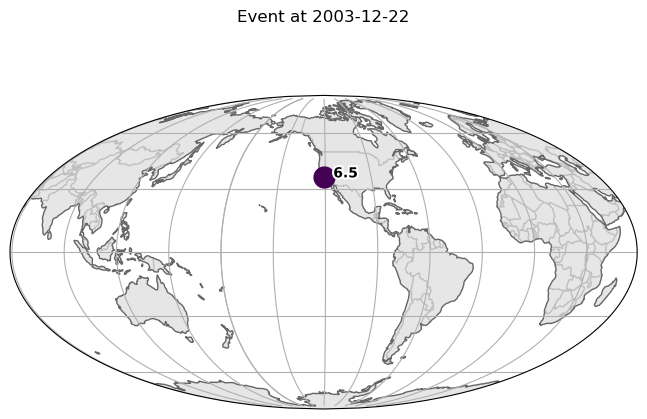

In [5]:
from obspy.core import UTCDateTime
search_location = (inv[0][0][0].latitude, inv[0][0][0].longitude)
eqs = ncedc_client.get_events(UTCDateTime("2003-01-01T00:00:00.000"),
                              UTCDateTime("2004-01-01T00:00:00.000"),
                              minmagnitude=6, latitude=search_location[0],
                              longitude=search_location[1], maxradius=10)
print(eqs)
eqs.plot();

The only earthquake matching these criteria is the San Simeon earthquake. The Catalog object returned by the webservice contains a list of Event objects, which in turn contain Origin objects listing available information on the source mechanism:

In [6]:
sansim = eqs[0]
sansimsource = sansim.origins[0]
print(sansim)
print(sansimsource)

Event:	2003-12-22T19:15:56.240000Z | +35.700, -121.100 | 6.5  Mw | manual

	            resource_id: ResourceIdentifier(id="quakeml:nc.anss.org/Event/NC/21323712")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='NC', creation_time=UTCDateTime(2008, 7, 10, 17, 0, 24), version='0')
	    preferred_origin_id: ResourceIdentifier(id="quakeml:nc.anss.org/Origin/NC/6605459")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:nc.anss.org/Netmag/NC/3924669")
	                   ---------
	                origins: 1 Elements
	             magnitudes: 1 Elements
Origin
	        resource_id: ResourceIdentifier(id="quakeml:nc.anss.org/Origin/NC/6605459")
	               time: UTCDateTime(2003, 12, 22, 19, 15, 56, 240000)
	          longitude: -121.1005
	           latitude: 35.7005
	              depth: 8382.0 [uncertainty=600.0]
	         depth_type: 'from location'
	         time_fixed: False
	    epicenter_fixed: False
	          method_id: ResourceI

You can use this to define a time span for beamforming. Given the earthquake's proximity to the array, take the origin time as starting time for beamforming, and set the end about two minutes after that. You can then reduce the inventory to the channel objects relevant for that time:

In [7]:
t_start = sansimsource.time
time_span = 130
t_end = t_start + time_span
inv = inv.select(starttime=t_start, endtime=t_end)
print(inv)

Inventory created at 2024-03-14T09:55:59.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.2
		    http://service.ncedc.org/fdsnws/station/1/query?net=BP&level=resp
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			BP
		Stations (13):
			BP.CCRB (Cholame Creek, Parkfield, CA, USA)
			BP.EADB (Eade Ranch, Parkfield, CA, USA)
			BP.FROB (Froelich Ranch, Parkfield, CA, USA)
			BP.GHIB (Gold Hill, Parkfield, CA, USA)
			BP.JCNB (Joaquin Canyon North, Parkfield, CA, USA)
			BP.JCSB (Joaquin Canyon South, Parkfield, CA, USA)
			BP.LCCB (Little Cholame Creek, Parkfield, CA, USA)
			BP.MMNB (Middle Mountain, Parkfield, CA, USA)
			BP.RMNB (Gastro Peak, Parkfield, CA, USA)
			BP.SCYB (Stone Canyon, Parkfield, CA, USA)
			BP.SMNB (Stockdale Mountain, Parkfield, CA, USA)
			BP.VARB (Varian Well, Parkfield, CA, USA)
			BP.VCAB (Vineyard Canyon, Parkfield, CA, USA)
		Channels (39):
			BP.CCRB..BP1, BP.CCRB..BP2, BP.CCRB..BP3, BP.EADB..BP1, 
			BP.EADB..BP2, BP.EADB

Now you have the inventory needed for three-component beamforming: three channels per station, with given locations. Note that if you want to analyse data over a time window where several channel objects exist for one physical channel, you must split your data and analysis into separate windows.

from functions.seismic_array import SeismicArray# Setting up the Array

Next, set up a SeismicArray object. This is the container for all array analysis routines; for example you can plot the array geometry. You can now also calculate the distance and backazimuth from the centre of the array to the earthquake.

In [8]:
from obspy_arraytools.seismic_array import SeismicArray
pfield = SeismicArray('pfield', inventory=inv)
# pfield.plot(projection='global')

from obspy.geodetics import gps2dist_azimuth
gps2dist_azimuth(pfield.center_of_gravity['latitude'],
                 pfield.center_of_gravity['longitude'],
                 sansimsource.latitude, sansimsource.longitude)

/tmp/ipykernel_235560/2556004223.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  gps2dist_azimuth(pfield.center_of_gravity['latitude'],


(61944.13522101383, 244.74920473738646, 64.38690878147916)

# Obtaining Data

Now to get the actual seismic data for analysis. This works very similarly to requesting an inventory. Again, request data from the BP network, for all channels starting with BP, for all available stations and locations. The beamforming requires all traces to be equally long (with the same number of samples), so keep only traces which cover the entire time span. Finally, deconvolve the instrument response to get velocity data and filter to a sensible frequency range.

In [9]:
all_data = ncedc_client.get_waveforms("BP", "*", "*", "BP*", t_start, t_end)
all_data.attach_response(pfield.inventory)

sampling_rate = all_data.traces[0].stats.sampling_rate
data = all_data.select(npts=time_span * sampling_rate)

data.remove_response(output="vel")
vel = data

freq_range = [0.1, .5]
vel.detrend(type='simple')
vel.filter('bandpass', freqmin=freq_range[0], freqmax=freq_range[1])
print(vel)

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

36 Trace(s) in Stream:

BP.CCRB..BP1 | 2003-12-22T19:15:56.251842Z - 2003-12-22T19:18:06.201842Z | 20.0 Hz, 2600 samples
...
(34 other traces)
...
BP.VCAB..BP3 | 2003-12-22T19:15:56.274884Z - 2003-12-22T19:18:06.224884Z | 20.0 Hz, 2600 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In this case, station JCNB did not provide data for the entire time, so there are only traces from 12 stations. This is still easily enough for beamforming. You can now update the inventory for the Parkfield array so that it does not list JCNB. This is done automatically when beamforming, but if you want e.g. accurate plots of the array geometry you may choose to do it explicitly. For this script, it is necessary because of the sensor orientation fix below.

In [10]:
pfield.inventory_cull(vel)
# See the updated inventory:
print(pfield.inventory)

Inventory created at 2024-03-14T09:55:59.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.2
		    http://service.ncedc.org/fdsnws/station/1/query?net=BP&level=resp
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			BP
		Stations (12):
			BP.CCRB (Cholame Creek, Parkfield, CA, USA)
			BP.EADB (Eade Ranch, Parkfield, CA, USA)
			BP.FROB (Froelich Ranch, Parkfield, CA, USA)
			BP.GHIB (Gold Hill, Parkfield, CA, USA)
			BP.JCSB (Joaquin Canyon South, Parkfield, CA, USA)
			BP.LCCB (Little Cholame Creek, Parkfield, CA, USA)
			BP.MMNB (Middle Mountain, Parkfield, CA, USA)
			BP.RMNB (Gastro Peak, Parkfield, CA, USA)
			BP.SCYB (Stone Canyon, Parkfield, CA, USA)
			BP.SMNB (Stockdale Mountain, Parkfield, CA, USA)
			BP.VARB (Varian Well, Parkfield, CA, USA)
			BP.VCAB (Vineyard Canyon, Parkfield, CA, USA)
		Channels (36):
			BP.CCRB..BP1, BP.CCRB..BP2, BP.CCRB..BP3, BP.EADB..BP1, 
			BP.EADB..BP2, BP.EADB..BP3, BP.FROB..BP1, BP.FROB..BP2, 
			BP.FROB..BP3, B

## Fixing sensor orientation

The BP data, being from borehole instruments, presents a problem with its orientation:

In [11]:
[print(st.code, st[0].dip, st[1].azimuth, st[2].azimuth)
 for st in pfield.inventory[0]]

CCRB 90.0 258.0 348.0
EADB 90.0 170.0 260.0
FROB 90.0 338.0 248.0
GHIB -90.0 170.0 260.0
JCSB -90.0 300.0 210.0
LCCB 90.0 50.0 140.0
MMNB 90.0 175.0 265.0
RMNB 90.0 310.0 40.0
SCYB 90.0 342.0 72.0
SMNB 90.0 120.0 210.0
VARB 90.0 358.0 88.0
VCAB 90.0 200.0 290.0


[None, None, None, None, None, None, None, None, None, None, None, None]

BP1 (st[0]) is perfectly vertical, but the horizontal channels BP2 and BP3 (st[1] and st[2]) are oriented somewhat randomly. To do any sort of beamforming, the data must be oriented in North, East and Up directions. The following fix is somewhat lengthy, so you can simply skip over it (but still execute the code!) if your data is already rotated correctly, but it may be interesting anyway. 

The horizontal seismic data can of course be tranformed by some simple trigonometric calculations, for which Obspy handily provides functions. Appropriate for this case is a rotation from radial and transverse components to North and East. However, we must first define channels as radial and transverse, and update the trace headers to match. Following a left-handed system of radial, transverse, and up, we define the radial component as that which is 'left' of the other: For example, if the BP3 channel has an azimuth of 90 degrees, and BP2 has 180, BP3 is the radial component with a backazimuth of 270 degrees.

In [12]:
# Split the inventory:
inv2 = pfield.inventory.select(channel="BP2")
inv3 = pfield.inventory.select(channel="BP3")
# Iterate through the stations in both inventories in parallel, choosing
# radial/transverse channels:
for st2, st3 in zip(inv2[0], inv3[0]):
    bp2 = st2[0].azimuth
    bp3 = st3[0].azimuth
    if (bp2 - bp3 == 90) or (bp3 >= 270 and bp2 < 90):
        radial = bp3
    elif (bp3 - bp2 == 90) or (bp2 >= 270 and bp3 < 90):
        radial = bp2
    else:
        raise ValueError("Channels aren't at right angles.")
    back_azimuth = radial - 180 if radial >= 180 else radial + 180
    new_suffixes = ['T', 'R'] if radial == bp3 else ['R', 'T']

    # Streams containing just one trace, for the current station:
    current_stream2 = vel.select(channel='BP2', station=st2.code)
    current_stream3 = vel.select(channel='BP3', station=st3.code)

    # The channel code in the headers of all traces must be changed from e.g.
    # BP2 to BPR:
    for tr, suffix in zip([current_stream2[0], current_stream3[0]],
                          new_suffixes):
        tr.stats.channel = tr.stats.channel[:-1] + suffix

    # Rotate the seismic data. This updates the
    # channel codes of the streams to BPN and BPE.
    combined_streams = current_stream2 + current_stream3
    combined_streams.rotate('RT->NE', back_azimuth)

    # The information in the inventory needs to be updated manually to reflect
    # the new channel orientations and codes. Remember st2 and st3 only contain
    # a single channel each.
    new_N = st2.channels[0] if radial == bp2 else st3.channels[0]
    new_E = st3.channels[0] if radial == bp2 else st2.channels[0]
    new_N.azimuth = 0
    new_N.code = new_N.code[:-1] + 'N'
    new_E.azimuth = 90
    new_E.code = new_E.code[:-1] + 'E'

# Finally, rename the vertical channels in both the data streams and the
# inventory:
for tr in vel.select(channel='BP1'):
    tr.stats.channel = tr.stats.channel[:-1] + 'Z'
for st in pfield.inventory.select(channel='BP1')[0]:
    for ch in st:
        ch.code = ch.code[:-1] + 'Z'

The data is now oriented in North, East and Up components, with the trace headers and inventory updated to match.


# Beamforming

The three-component beamforming follows [Esmersoy1985]_. To use it, you need to decide on some paramaters: The beamforming is performed on a sliding window, for which you need to choose a sensible length, to ensure coherency in the signal, and overlap (default is no overlap which runs
fastest). At a minimum, the window length must be long enough to allow a signal with the highest chosen slowness to propagate across the entire array.  It is also possible to average the covariance matrix over a number  of windows. You also need to define a slowness range, as the beamforming is performed for discrete values of slowness. This will partly depend on the chosen wavetype: This algorithm can (with some caveats) distinguish P,
 SV, Love, and prograde or retrograde Rayleigh waves. Similarly, you need to define a frequency range that most sensibly has the same
minimum/maximum as that to which the data was previously filtered.
You may also choose to whiten the frequency spectrum before beamforming and/or normalise the
 resulting powers.

In [13]:
# Define a slowness range in seconds per km:
s_min, s_max, s_step = [0, 0.6, 0.03]
# Define window length in seconds (powers of 2 make for faster Fourier
# transforms):
window_length = 64
# Need separate streams:
vel_n = vel.select(channel='BPN')
vel_e = vel.select(channel='BPE')
vel_z = vel.select(channel='BPZ')
out = pfield.three_component_beamforming(vel_n, vel_e, vel_e, window_length,
                                         s_min, s_max, s_step, wavetype='P',
                                         freq_range=freq_range, whiten=True)

/home/andbro/notebooks/RomyArray/obspy_arraytools/seismic_array.py:1841: UserWarning: Moving frequency window is True, it equals or exceeds the entire frequency range and was set to 0.01 now.
  warnings.warn(msg % whiten)


The result has a range of plotting options attached. You can also plot the array response function.

/home/andbro/notebooks/RomyArray/obspy_arraytools/beamforming_result.py:826: UserWarning: The following kwargs were not used by contour: 'linstyles'
  contf = ax.contourf(theo_backazi, self.slowness_range, bfres.T,


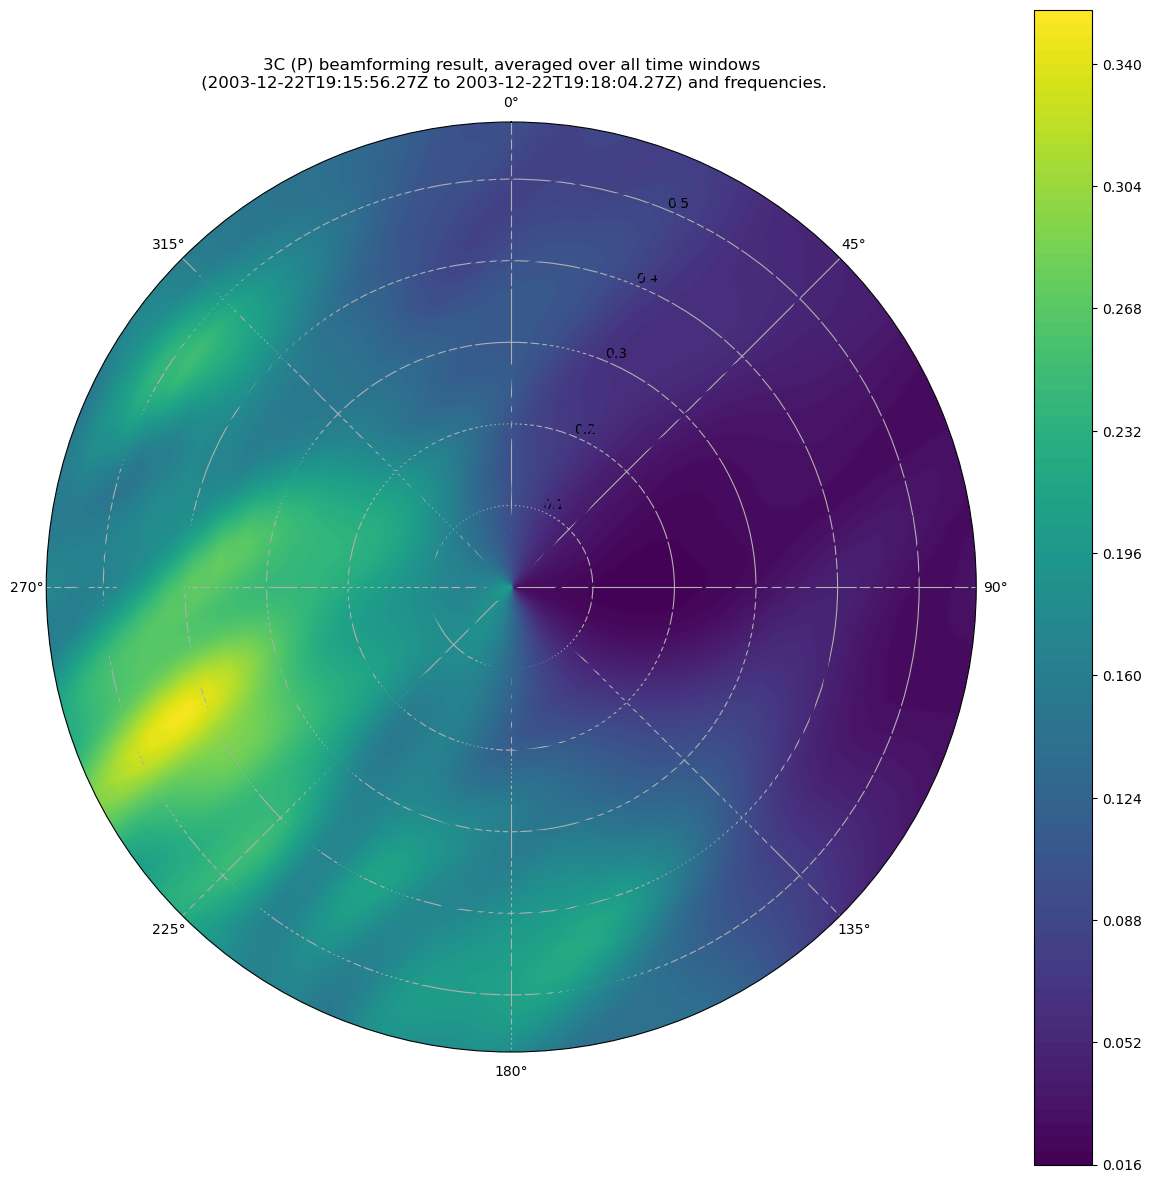

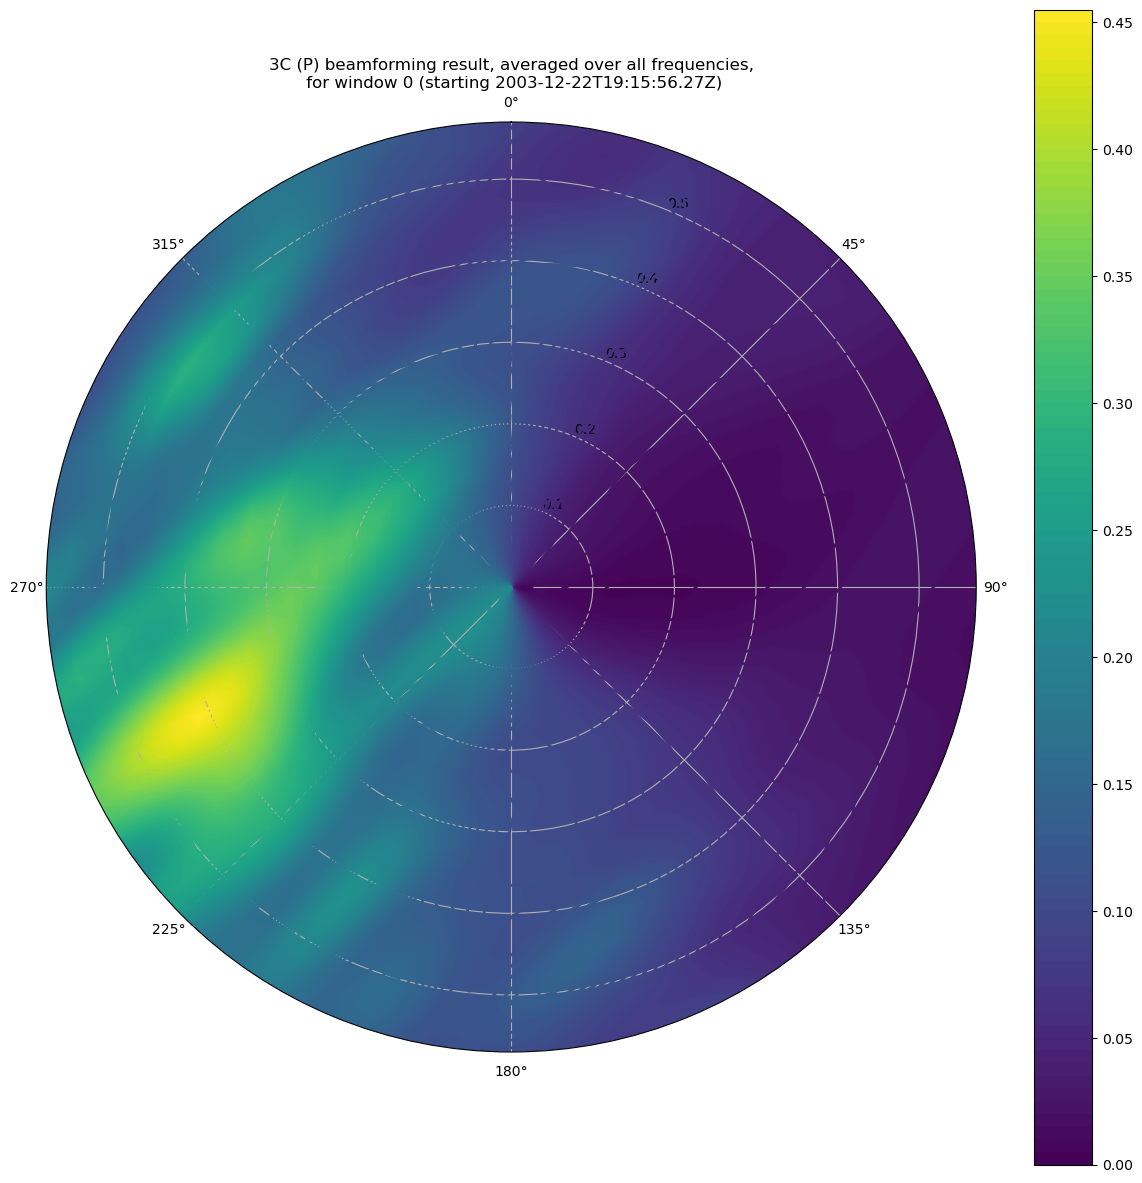

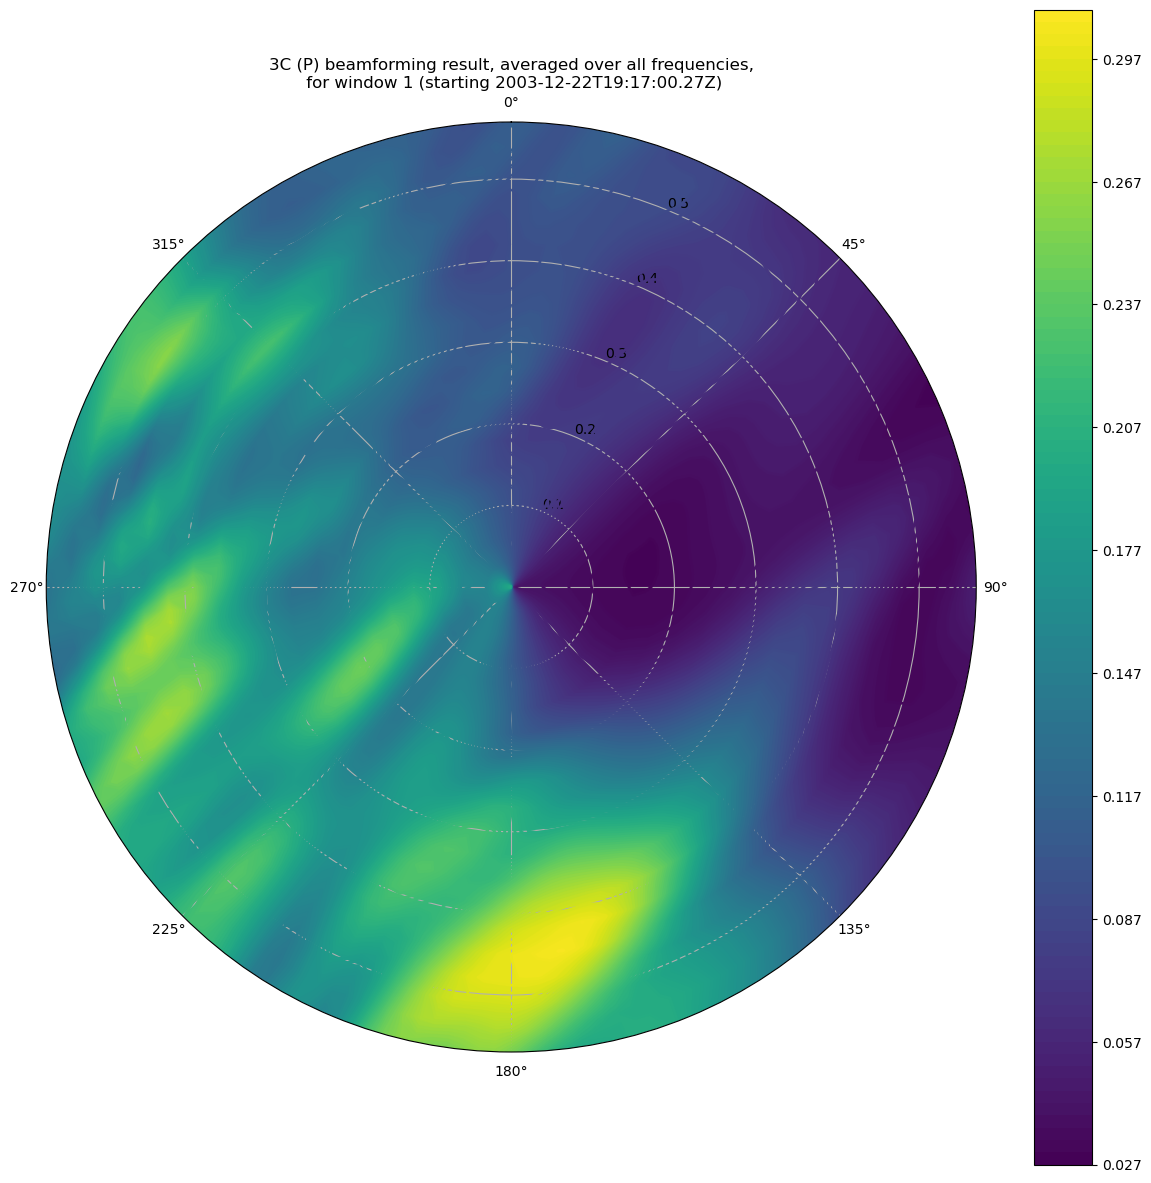

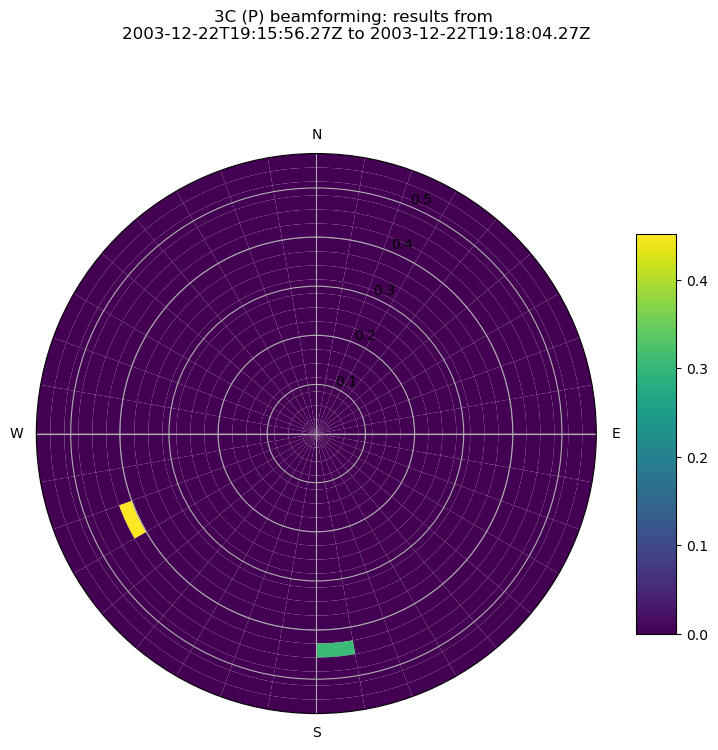

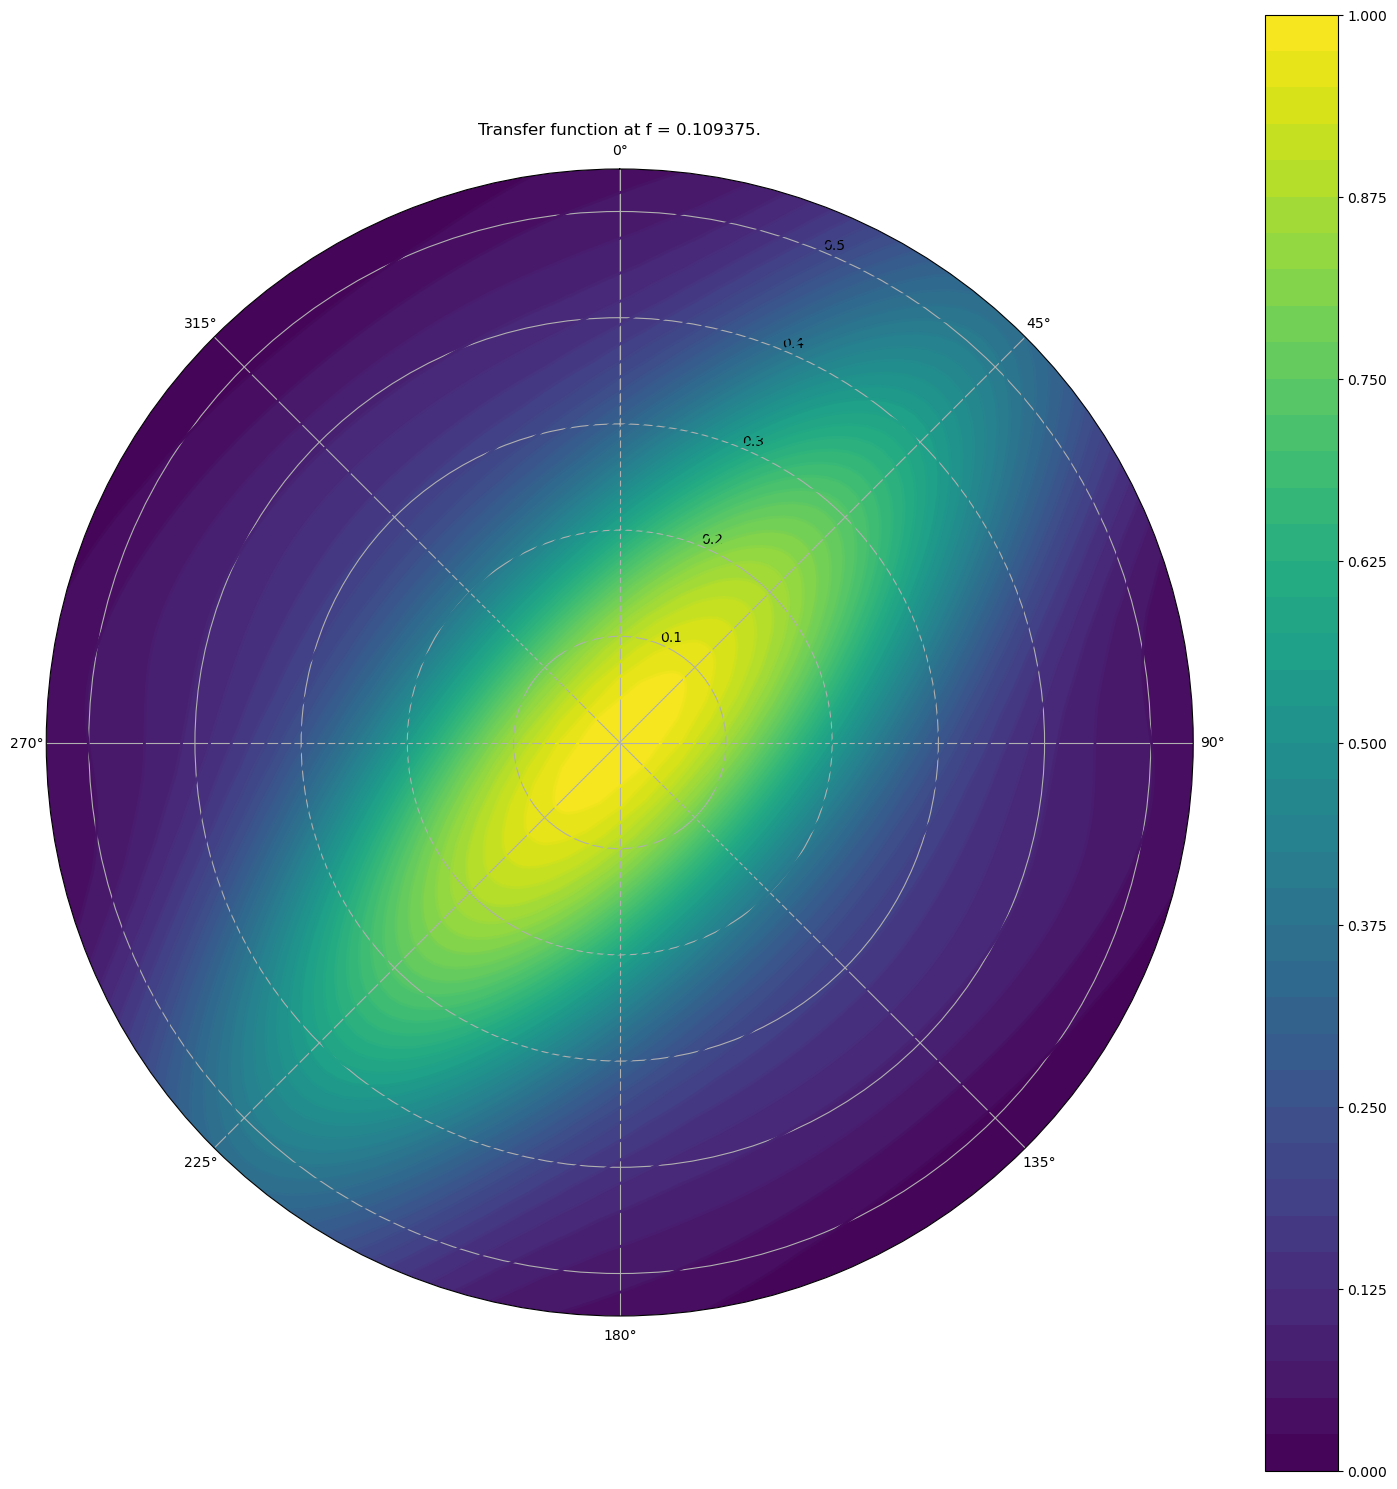

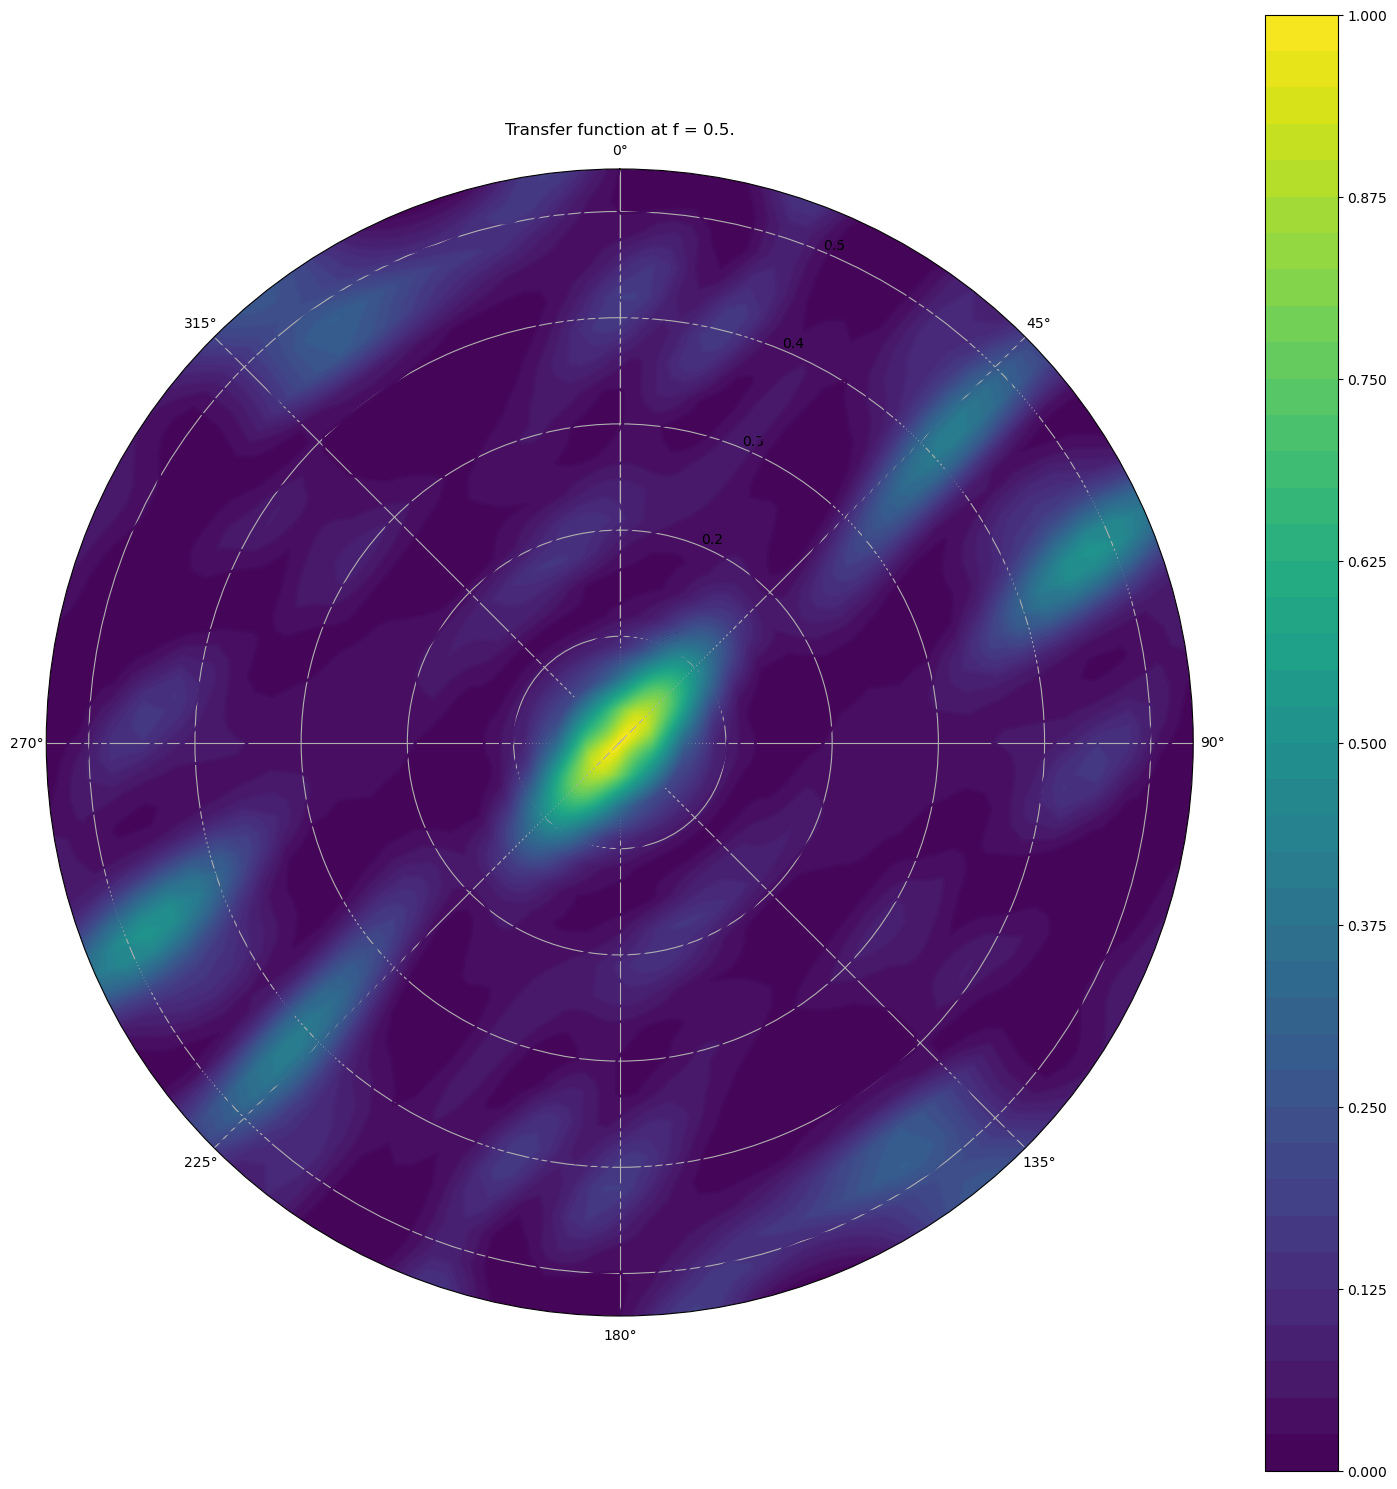

In [14]:
out.plot_bf_plots(show=False)
out.plot_bf_plots(average_windows=False, show=False)
out.plot_baz_hist(show=True)

out.plot_radial_transfer_function()